Este trabalho foi desenvolvido com base no trabalho disponibelizado sobre Quantum Edge Detection no Qiskit Textbook.

# **Implementation using Qiskit: QHED on Small Images**

In [1]:

from qiskit import *
from qiskit import QuantumCircuit, Aer, execute
from qiskit import IBMQ 
from qiskit.compiler import transpile, assemble
import qiskit.tools.jupyter
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import *
from qiskit.visualization import array_to_latex, plot_distribution, plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Batch, Options

import math
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import style 
from PIL import Image

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import cv2

style.use('bmh')

## Running on The Simulator

For the purpose of this demonstration, we can assume that an image is nothing but a collection of pixel values represented as a numpy matrix in python. Also, initially let us take only binary values for pixels for simplocity i.e. **$I_{j,k} \in \{0,1\}$**, and there are no floating point values for pixel intensities.

Later we'll see that the same algorithm can also be used with proper 8-bit B&W images.

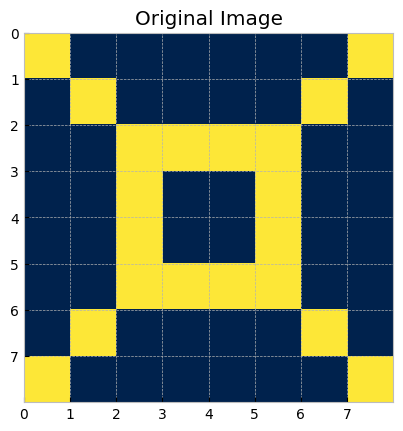

In [2]:
# a 8*8 binary image represented as a numpy array
image = np.array([
    [1, 0, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [1, 0, 0, 0, 0, 0, 0, 1],
])

def plot_image (img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap = 'cividis')
    plt.show()

plot_image(image, 'Original Image')

Now that we have defined our image for testing, we can go ahead and use the following equation to encode pixel intensities as probability amplitudes of different states of the system.

$c_i = \frac{I_{yx}}{\sqrt{\sum I_{yx}^2}}$

In [3]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    #Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))

    #create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele/rms)

    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude encoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

#Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

As can be seen in the above python code, we obtain two different amplitude encoded quantum images. The first one (image_norm_h) is for the horizontal scanning of the image and the second one (image_norm_v) is for the vertical scanning of the image.

After this we initialize the number of qubits and the amplitude permutation unitiray like so,

In [4]:
# Initialize some global variable for number of qubits

data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis = 1)

Once, we have normalized the pixel values, converted them to probability amplitudes, and determined the number of qubits necessary for processing the image, we can start making the quantum circuit for the same.

Since, our image now basically represents the amplitudes of different quantum states, we can directly use the initialize() method to perform the state preparation. After this, we add a Hadamard gate to the auxiliary qubit, then the amplitude permutation unitary, and then again a Hadamard gate to auxiliary qubit. Also, the whole circuit is repeated once more for the vertical scanning of image.

c:\Users\alexa\anaconda3\envs\CQ_env\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


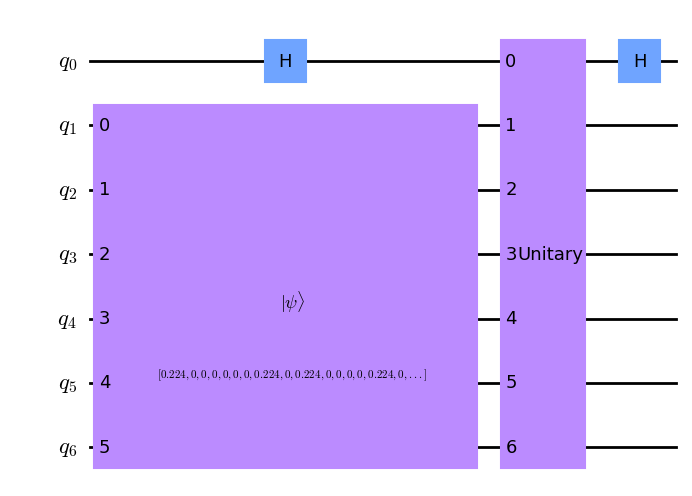

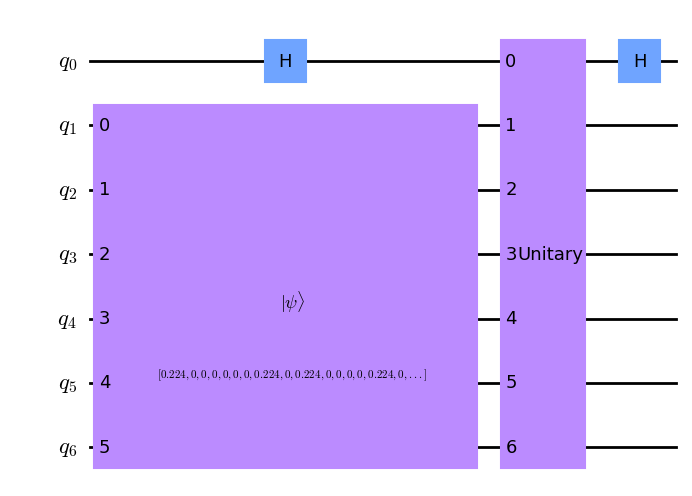

In [5]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

#Combine both circuits into a single list 
circ_list =  [qc_h, qc_v]

Now, we simulate the circuits using the statevector_simulator and obtain the statevector of the system as the output.

In [6]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

print('Horizontal scan statevector:')
display(array_to_latex(sv_h, max_size=30))
print()
print('Vertical scan statevector:')
display(array_to_latex(sv_v, max_size=30))

Horizontal scan statevector:


<IPython.core.display.Latex object>


Vertical scan statevector:


<IPython.core.display.Latex object>

From eq. III.3, we can clearly see that we need to consider only those states where the auxiliary qubit (qubit-0 or LSB in our case) gives a measurement output of $\big | 1 \big >$. Since, we know that LSB is 1 in a bit-strong only for odd numbers, we easily just take the amplitudes corresponding to odd states from the statevector to form our image and discard all the even states.

The following code, performs this task along with some classical post-processing to ensure that we get the best results when we plot our image. After we filter the required states from the raw statevector, we can rearrage the 1D array of amplitudes to a 2D matrix to get our edge detected horizontal and vertical scans like so,


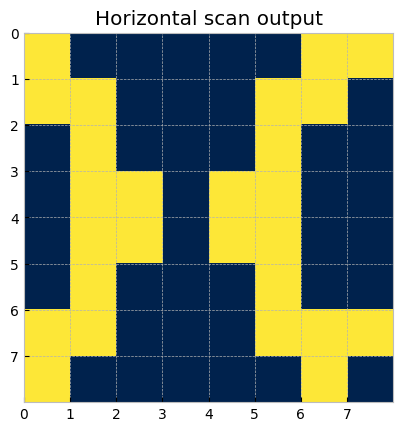

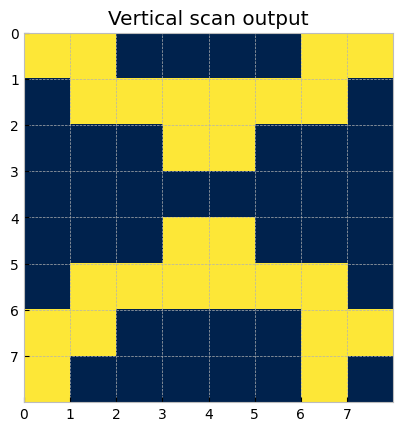

In [7]:
# Classical postprocessing for plotting the output

# Defining a Lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp <-1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8*8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8,8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8,8).T 

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

Finally, we combine both horizontal and vertical scans to get the complete edge detected image as shown below,

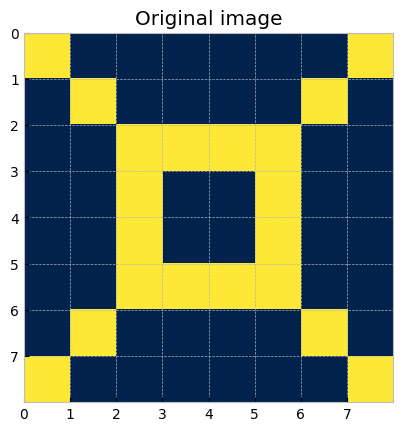

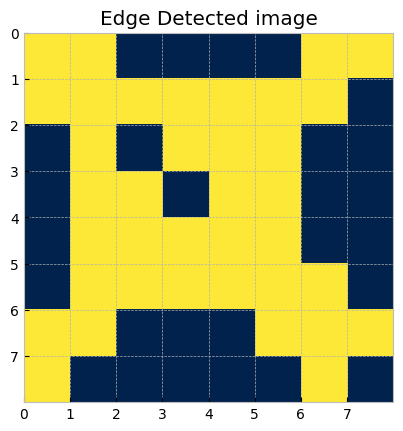

In [8]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

## Running on Real Hardware
This section takes a part of the previously simulated image (represend by qc_h and qc_v) and runs them on the least occupied machine backend to test the running the algorithm on a real quantum computer with inherent noise and error characteristics specific to the hardware.

First we import and load our IBMQ account.

In [9]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='a7620ee54ce46abd258f5a201c603548e031b89cd7abd9ccce5894cf30228bbb46e365da88d9d66c812520e9fcd2265a488931c473ef4097fe6c1f834acb4dd7'
)
options = Options(optimization_level=1)

# Get provider and backend
backend = service.least_busy(operational=True, simulator=False)
backend.name

'ibm_osaka'

Since, running on actual harware deals with encoutering errors due to noise, we only limit this example to run on (2+1)-qubits as of now. For the demonstration, now we can crop a part of the above image that was used in the simulation.

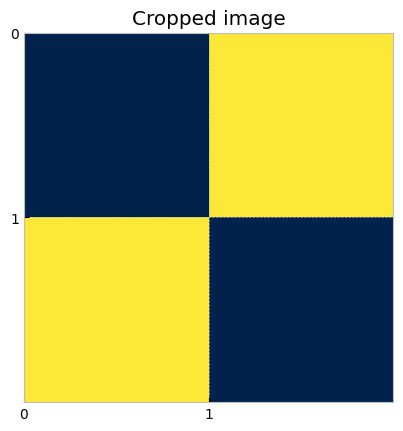

In [10]:
# Create a 2*2 image to be run on the hardware
# The pixels in 'image_small' correspond to the pixels at 
# (,), (,), (,), (,) respectively
image_small = image[5:7, 1:3]

# Plotting the image_small using matplotlib
plot_image(image_small, 'Cropped image')

Defining the parameters for the quantum circuit of the QHED algorithm and creating instances of horizontal and vertical scan circuits.

For the Horizontal and Vertical scan of the above image, we can see that the operations for state-preparation and decrement gate be written as follows:

**Horizontal Scan:**
1. State preparation $\big ( \big | Img \big > = \big | 01 \big> \big)$: We can achieve this with a simple $[X(1)]$ operation.
2. Decrement gate: We can achieve this by a sequence of $[X(0), CX(0,1), CCX(0, 1, 2)]$ operations.

**Vertical Scan:**
1. State preparation $\big ( \big | Img \big > = \big | 10 \big> \big)$: We can achieve this a simple $[X(2)]$ operation.
2. Decrement gate: We can achieve this by a sequence of $[X(0), CX(0,1), CCX(0, 1, 2)]$ operations.

In [11]:
# Initialize the number of qubits
data_qb = 2
anc_qb = 1
total_qb = data_qb + anc_qb

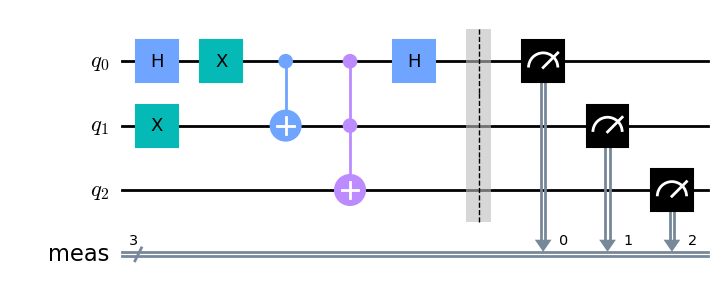

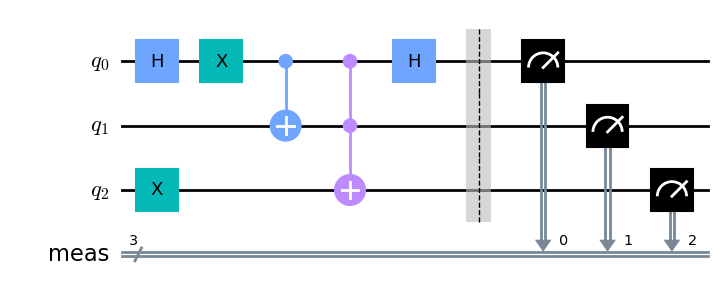

In [12]:
# Create the circuit for horizontal scan
qc_small_h = QuantumCircuit(total_qb)
qc_small_h.x(1)
qc_small_h.h(0)
# Decrement gate - START
qc_small_h.x(0)
qc_small_h.cx(0, 1)
qc_small_h.ccx(0, 1, 2)
# Decrement gate - END
qc_small_h.h(0)
qc_small_h.measure_all()
display(qc_small_h.draw('mpl'))

# Create the circuit for vertical scan
qc_small_v = QuantumCircuit(total_qb)
qc_small_v.x(2)
qc_small_v.h(0)
# Decrement gate - START
qc_small_v.x(0)
qc_small_v.cx(0, 1)
qc_small_v.ccx(0, 1, 2)
# Decrement gate - END
qc_small_v.h(0)
qc_small_v.measure_all()
display(qc_small_v.draw('mpl'))

# Combine both circuits into a single list
circ_list = [qc_small_h, qc_small_v]

For running the circuit on real hardware, it is necessary to decompose the above quantum circuit into the basis gates $(X, SX, RZ(\omega), CX)$ for the machine backend in order to run the circuit properly. To achieve this, we transpile the above circuit according to our backend's cpupling map and also set the optimization_level=3, to get the most optimized circuit according to the hardware.

In [13]:
# Transpile the circuits for optimized execution on the backend
qc_small_h_t = transpile(qc_small_h, backend=backend, optimization_level=3)
qc_small_v_t = transpile(qc_small_v, backend=backend, optimization_level=3)

c:\Users\alexa\anaconda3\envs\CQ_env\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


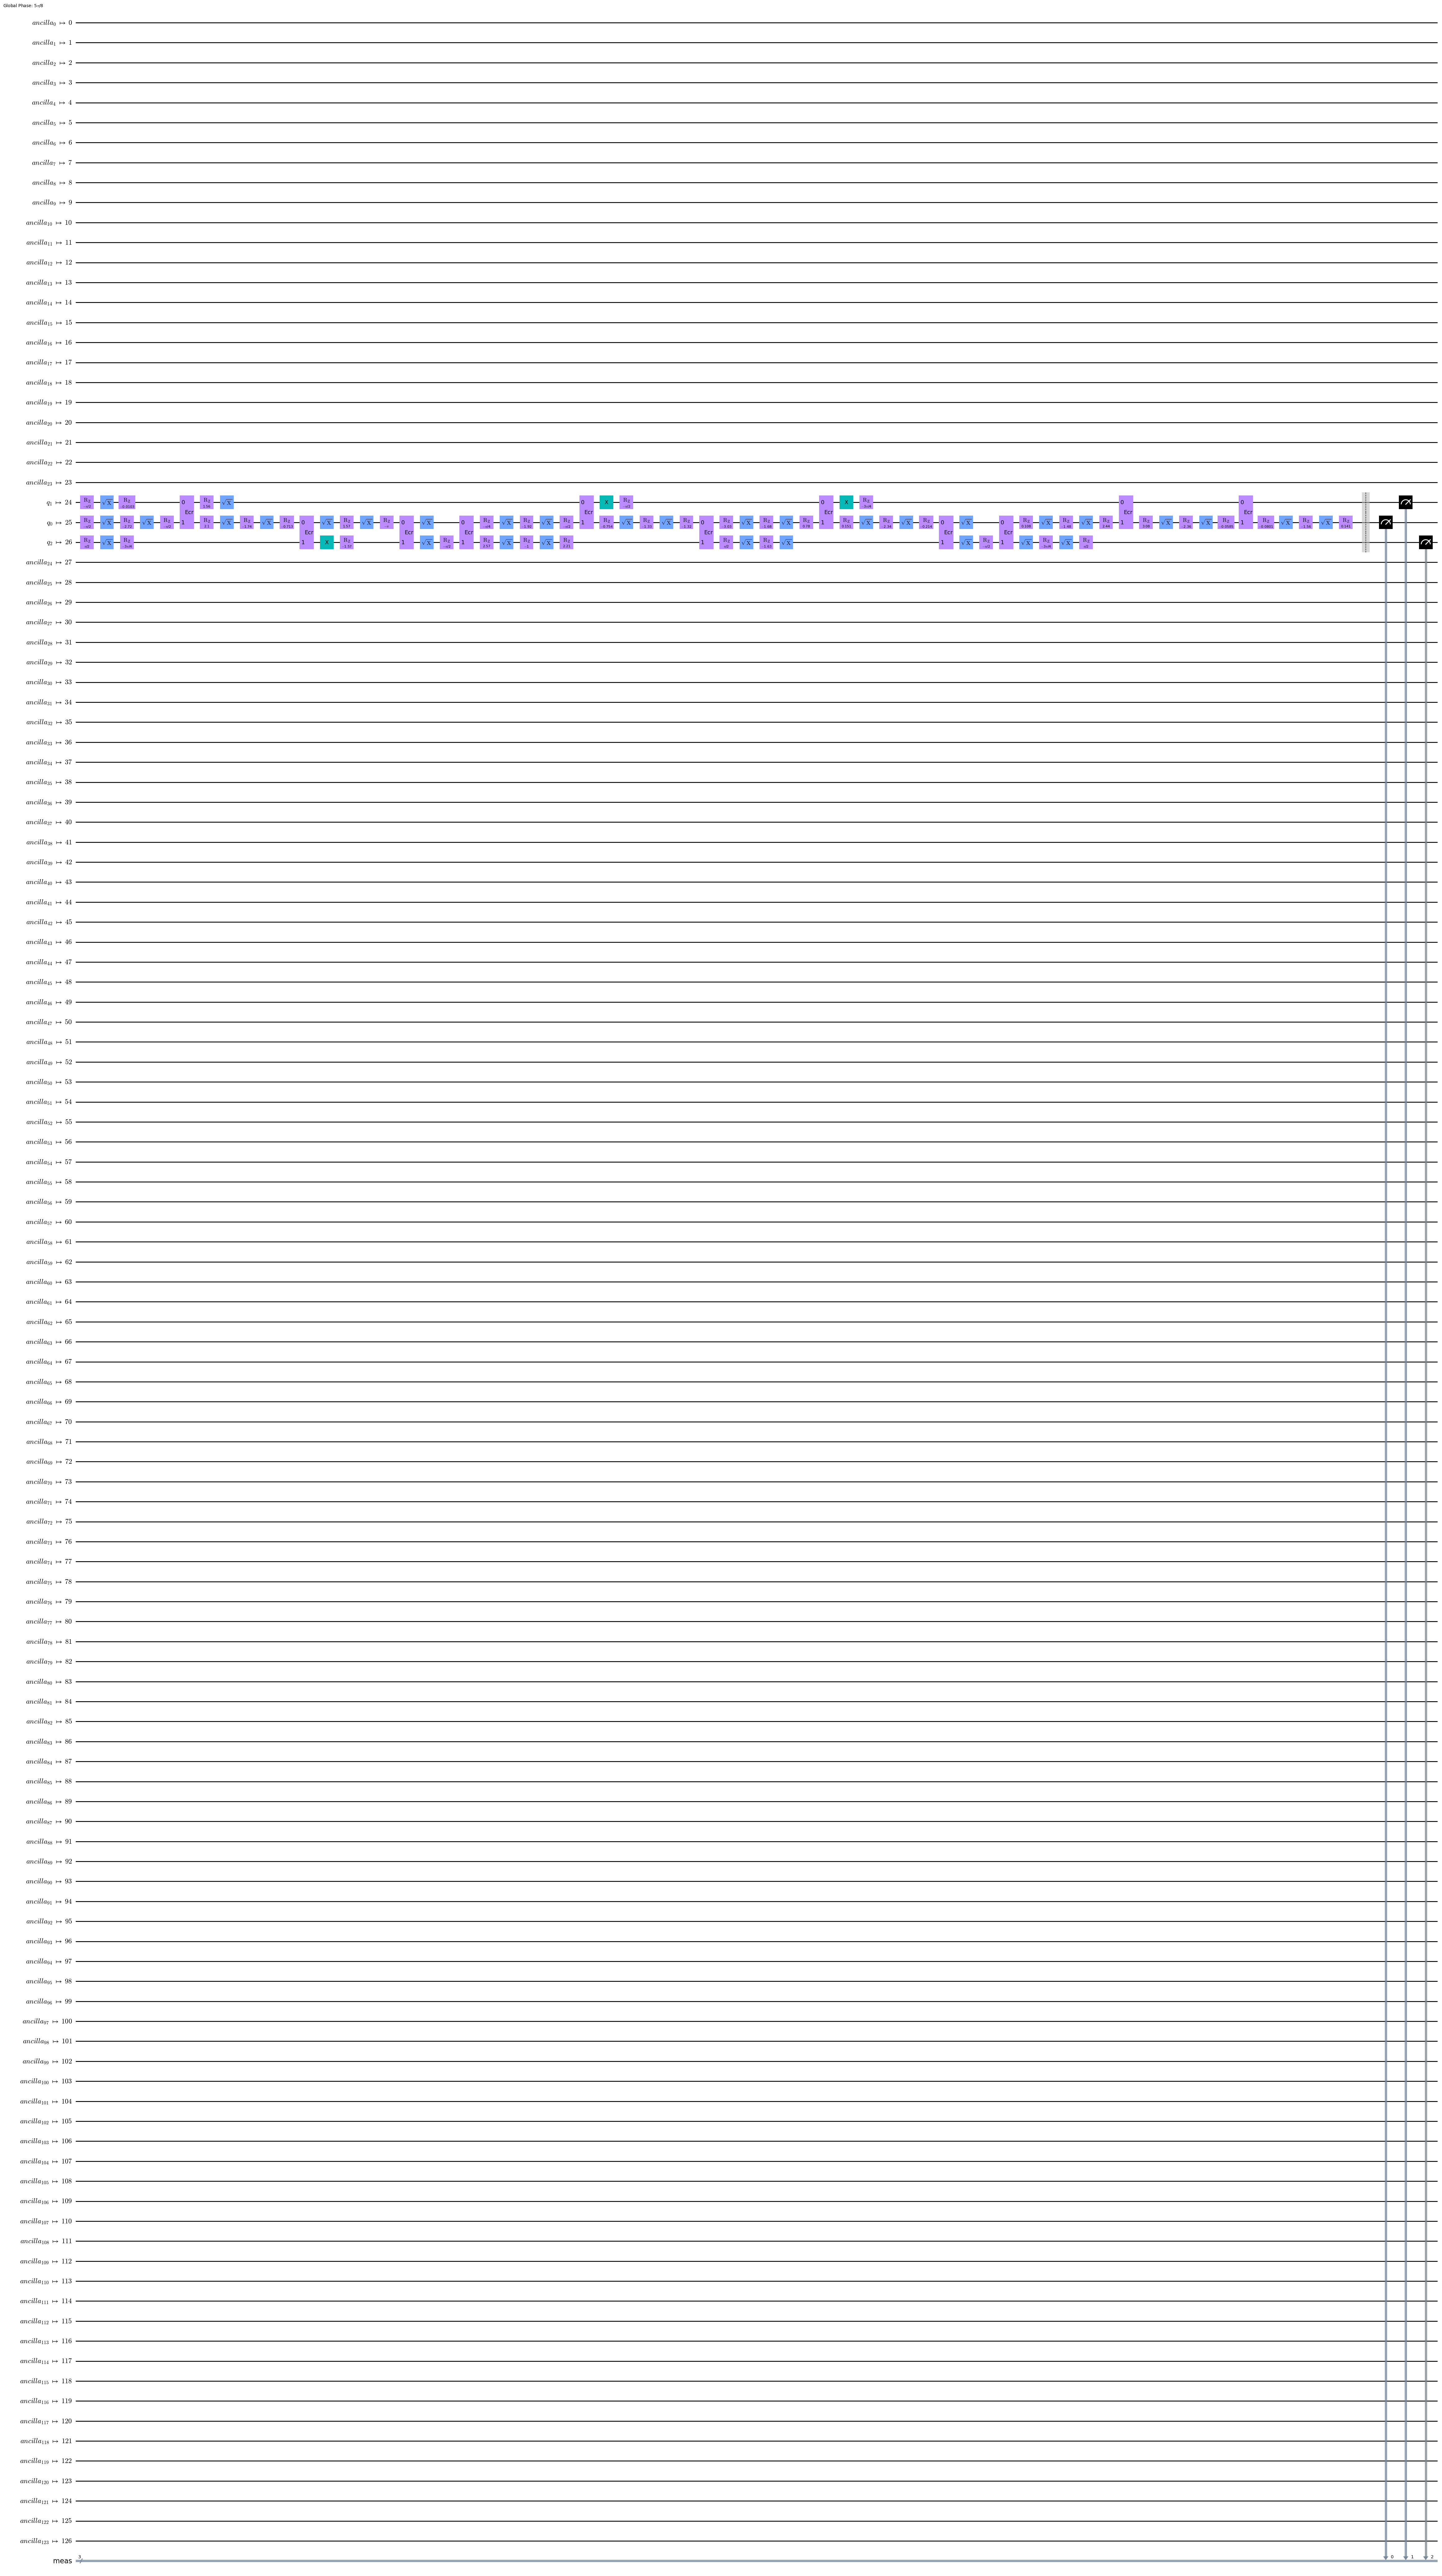

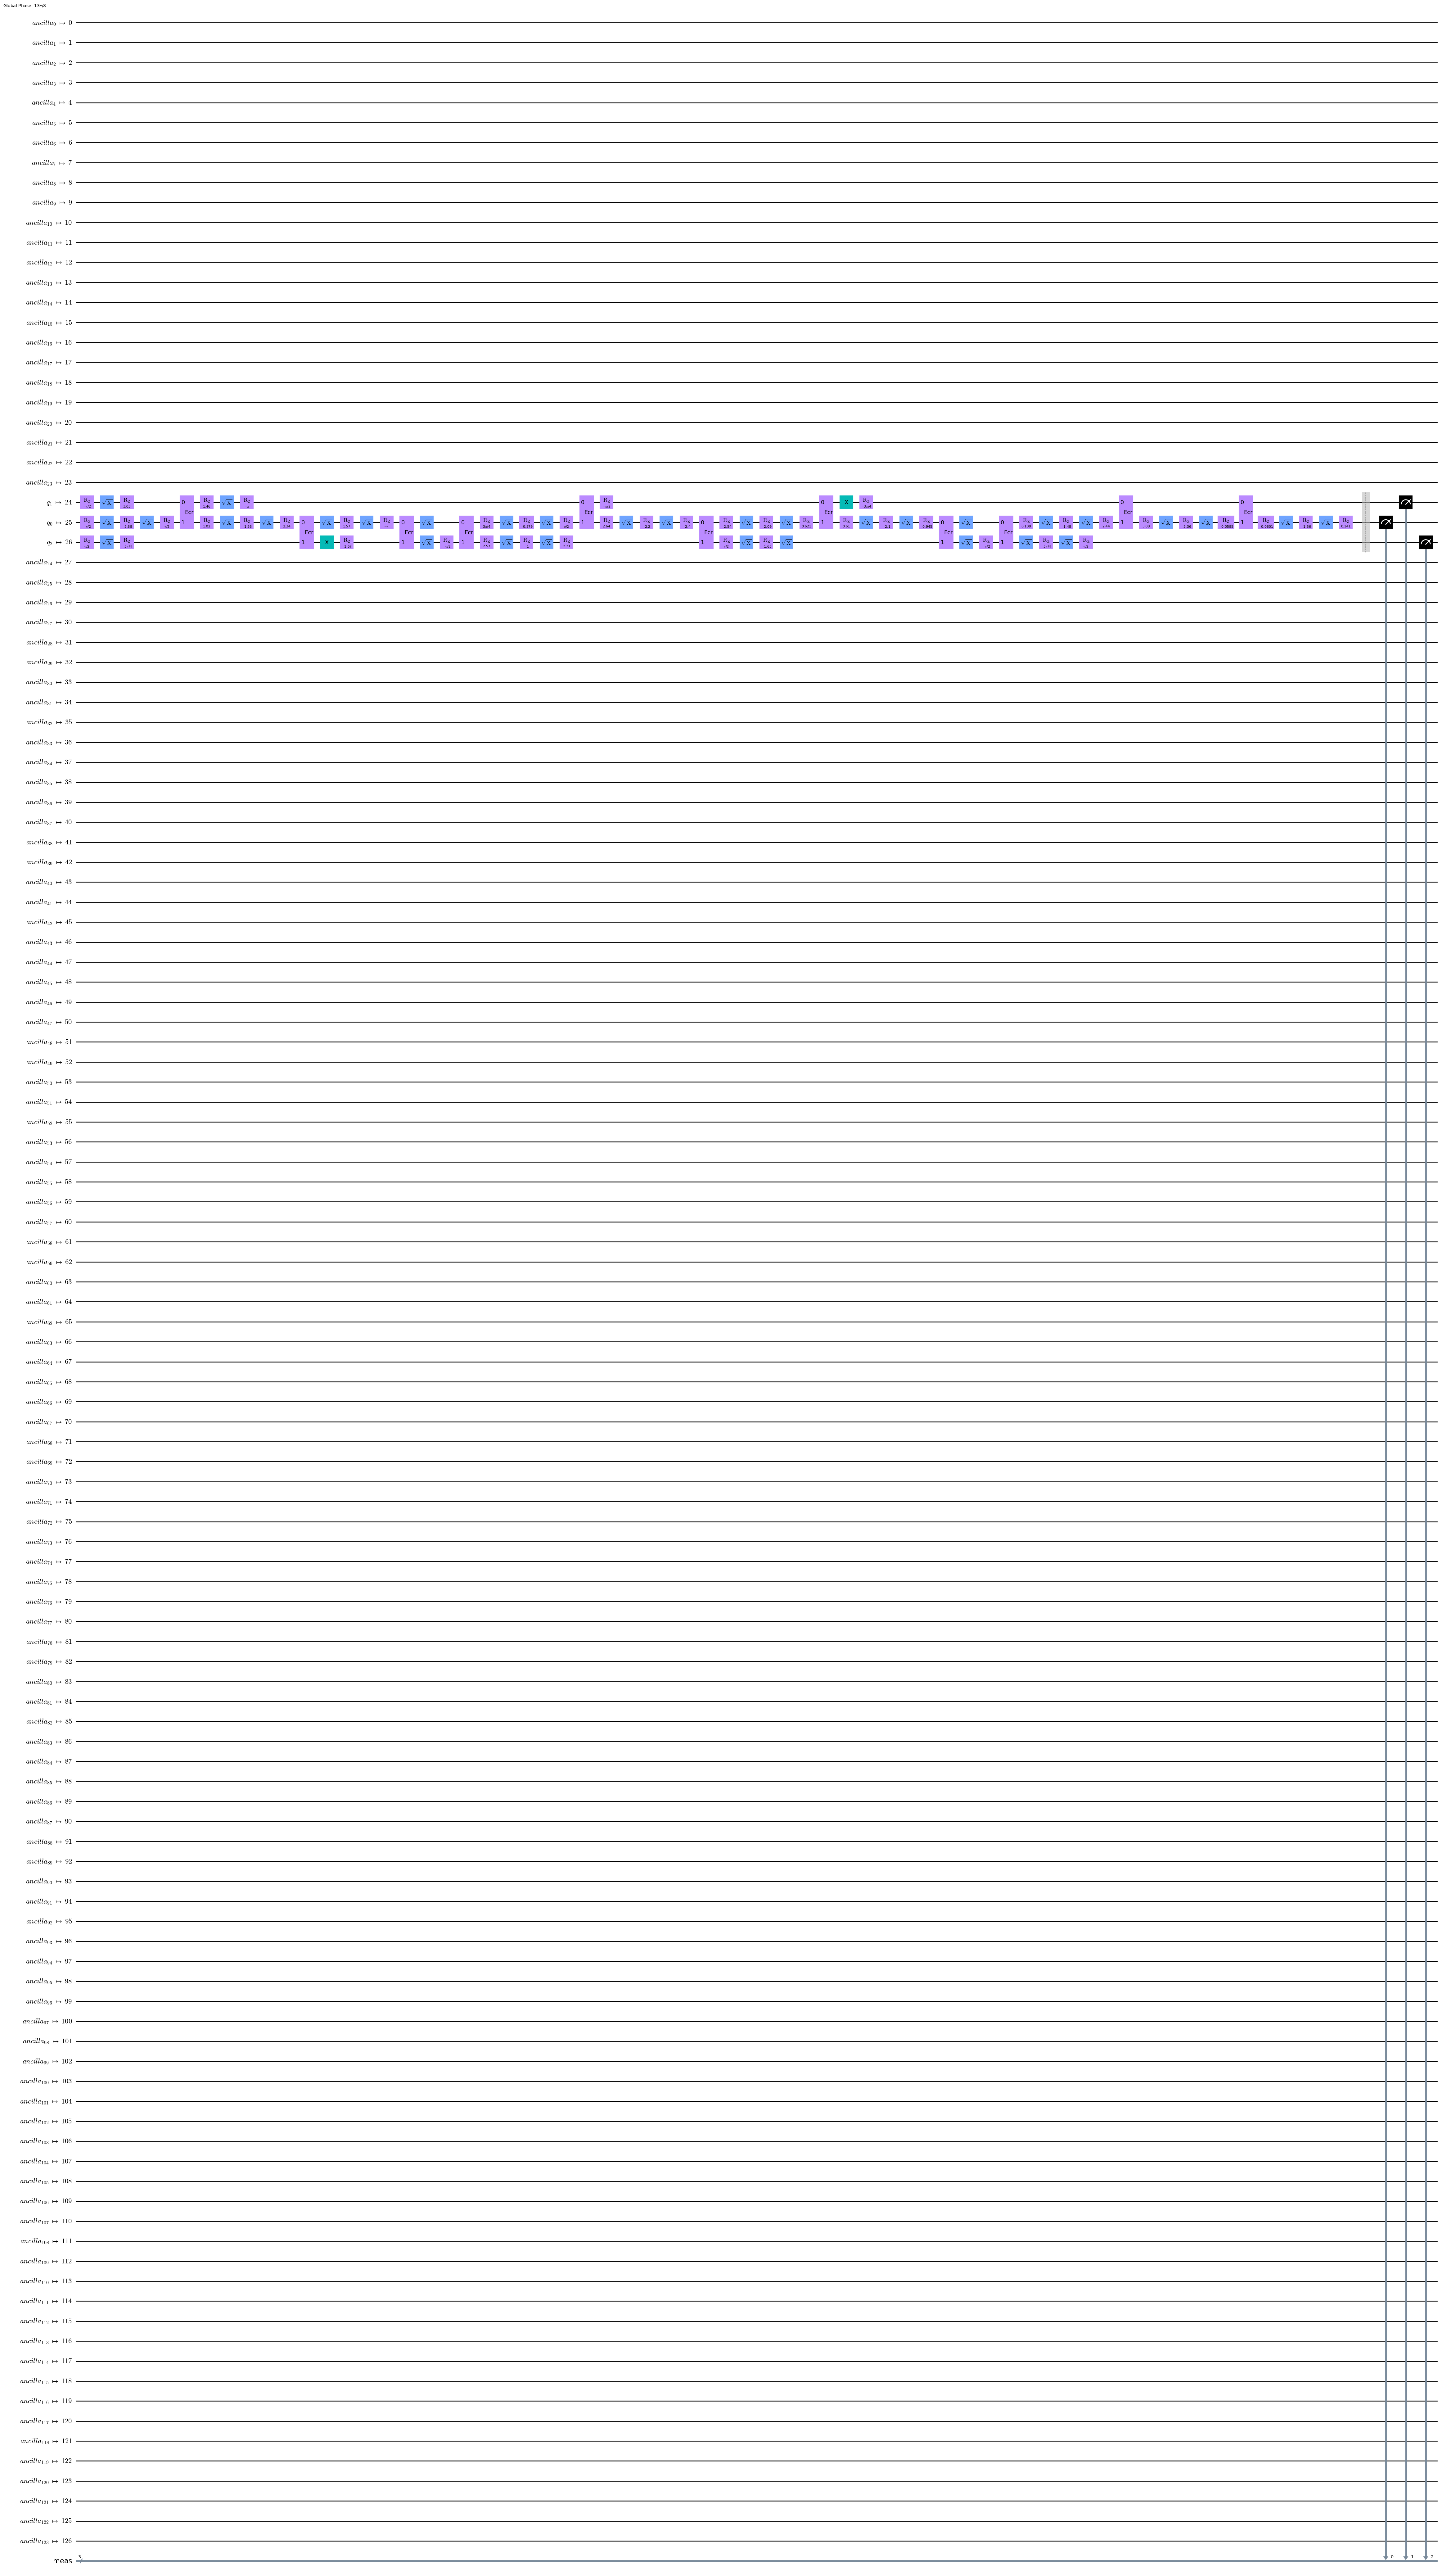

In [14]:
# Combining both transpile circuits into a list
circ_list_t = [qc_small_h_t, qc_small_v_t]

display(circ_list_t[0].draw('mpl', fold=-1))
display(circ_list_t[1].draw('mpl', fold=-1))

In [15]:
# Executing the circuits on the backend
job = execute(circ_list_t, backend=backend, shots=8192)
job_monitor(job)

Job Status: job is actively running

Counts for Horizontal scan:


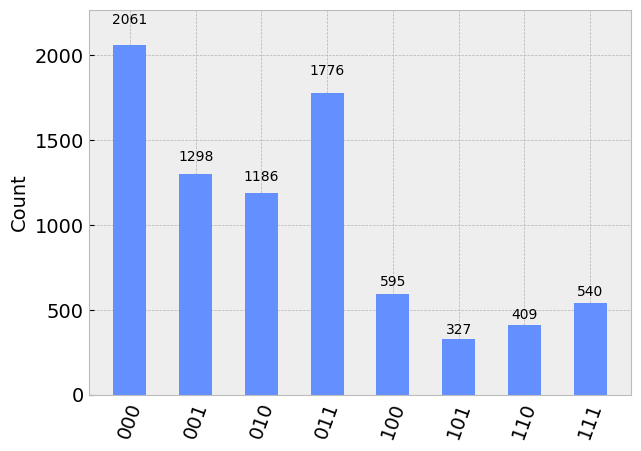

Counts for Vertical scan: 


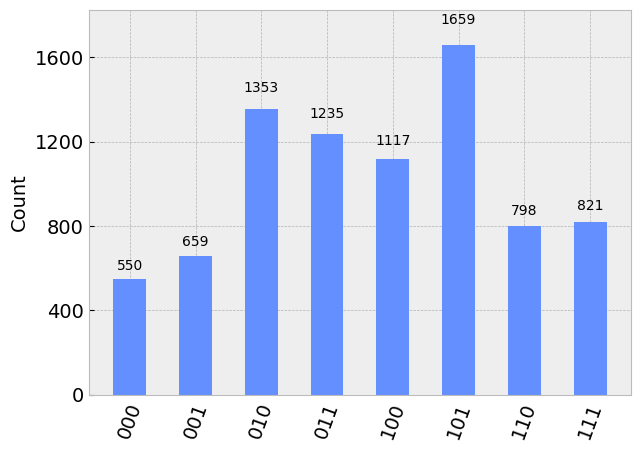

In [ ]:
# Getting the resultant probability distribuition after measurement
result = job.result()
counts_h = result.get_counts(qc_small_h)
counts_v = result.get_counts(qc_small_v)

print('Counts for Horizontal scan:')
display(plot_histogram(counts_h))

print('Counts for Vertical scan: ')
display(plot_histogram(counts_v))

Now, we extract the counts of the odd-numbered states from horizontal and vertical scans because only those states contain the pixel intensity gradient information in which the auxiliary qubit is in the state $\big | 1 \big >$.

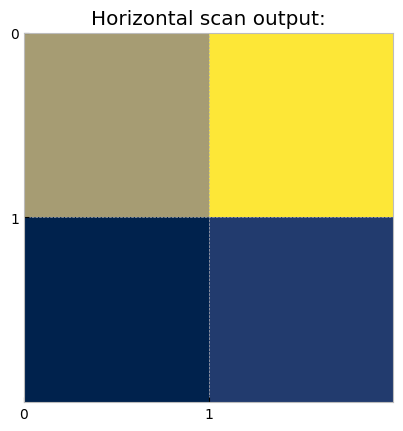

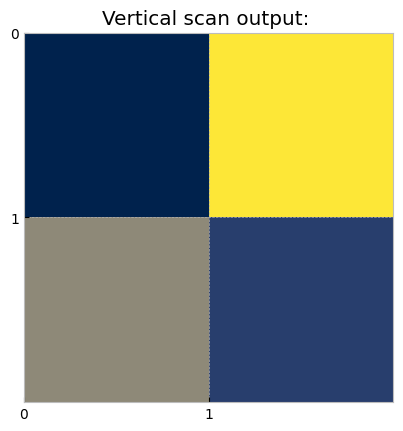

In [ ]:
# Extracting counts for odd-numbered states
edge_scan_small_h = np.array([counts_h[f'{2*i+1:03b}'] for i in range(2**data_qb)]).reshape(2,2)
edge_scan_small_v = np.array([counts_v[f'{2*i+1:03b}'] for i in range(2**data_qb)]).reshape(2,2).T 

plot_image(edge_scan_small_h, 'Horizontal scan output:')
plot_image(edge_scan_small_v, 'Vertical scan output: ')

Finally, we combine both horizontal and vertical scans to make the full edge detection cropped image as shown below,

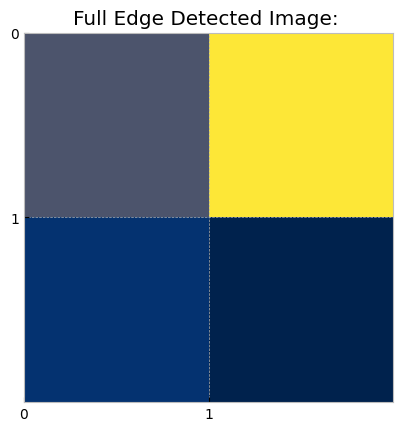

In [ ]:
edge_detected_image_small = edge_scan_small_h + edge_scan_small_v
plot_image(edge_detected_image_small, 'Full Edge Detected Image: ')

For comparison, let's simulate the quantum circuits on the qasm_simulator as well and check how the probability distribuition obtained from the real hardware, differs from a perfect simulation:

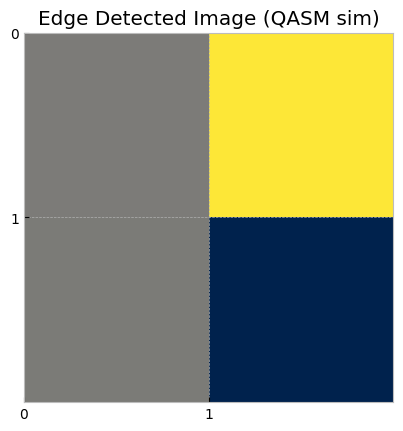

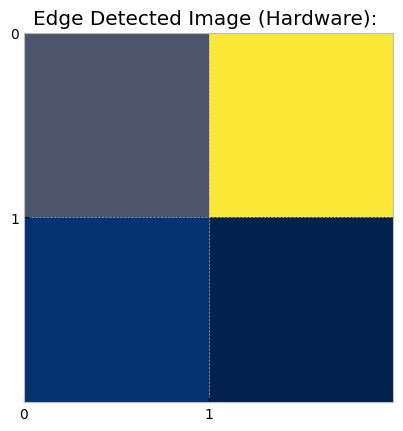

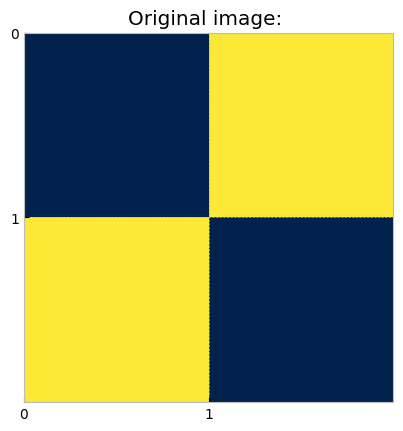

In [ ]:
# Initialize the qasm_simulator from the Aer Package
sim = Aer.get_backend('qasm_simulator')
res = sim.run(circ_list_t, shots=8192).result()
sim_counts_h = res.get_counts(qc_small_h)
sim_counts_v = res.get_counts(qc_small_v)

# Get the measurement counts from the result
sim_keys_h = sim_counts_h.keys()
sim_keys_v = sim_counts_v.keys()

# Filter and extract the counts for odd-numbered states
# and make the full edge-detected image by adding horizontal and vertical scans
edge_scan_sim_h = np.array([sim_counts_h[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_h else 0 for i in range(2**data_qb)]).reshape(2, 2)
edge_scan_sim_v = np.array([sim_counts_v[f'{2*i+1:03b}'] if f'{2*i+1:03b}' in sim_keys_v else 0 for i in range(2**data_qb)]).reshape(2, 2).T
edge_detected_sim_small = edge_scan_sim_h + edge_scan_sim_v

# Plot all the simulator-run, harware-run and original images
plot_image(edge_detected_sim_small, 'Edge Detected Image (QASM sim)')
plot_image(edge_detected_image_small, 'Edge Detected Image (Hardware): ')
plot_image(image_small, 'Original image: ')

# **QHED on Larger Images**

As the quantum technology advances, we will see more and more applications related to faster image processing and image manipulation. However, for processing insanely large data like 4k images and videos, one would have to process the image in multiple parts until we reach the stage of fault-tolerante quantum hardware.

This exercise tries to incorporate a similar workflow to perfom edge detection for an image which is approximately 1000 x 1000 larger than out previous 8 x 8 pixel image example. Hence, you (the reader) have to load a 256 x 256 pixel, 8-bit color, custom image and perform edge detection to it using the QHED algorithm as discussed in previous examples. 

Raw Image info:  (1024, 1024, 3)
Raw Image datatype:  uint8
Image shape (numpy array):  (1024, 1024)


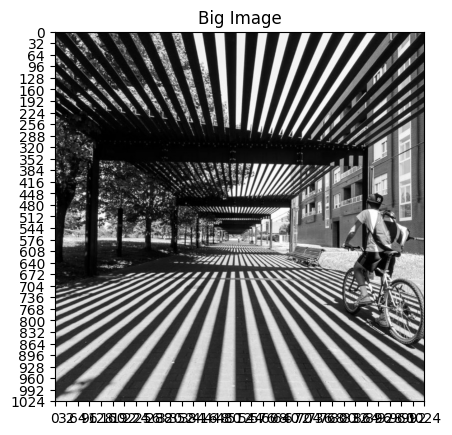

In [ ]:
style.use('default')

# Original image-width
image_size = 128      #128, 256, 512
# Width of each part of image for processing
image_crop_size = 16    #16,  32,  64

# Load the image from filesystem
image_raw = np.array(Image.open('./images/img02_grayScale.png'))
print('Raw Image info: ', image_raw.shape)
print('Raw Image datatype: ', image_raw.dtype)

# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)

image = np.array(image)
print('Image shape (numpy array): ', image.shape)

# Display the image
plt.title('Big Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='binary_r')
plt.show()

In [ ]:
# Get blocks from image and process them immediately as a small image
result = np.zeros((image_size,image_size))
block_count = int(image_size/image_crop_size)

for i in range(0,block_count):
    for j in range(0,block_count):
        mini_block = image[i*image_crop_size:(i+1)*image_crop_size,j*image_crop_size:(j+1)*image_crop_size]
        
        image_norm_h = amplitude_encode(mini_block)
        image_norm_v = amplitude_encode(mini_block.T)
        
        # Initialize some global variable for number of qubits
        if image_size == 128:
            data_qb = 8
        elif image_size == 256:
            data_qb = 10
        elif image_size == 512:
            data_qb = 12
        anc_qb = 1
        total_qb = data_qb + anc_qb

        # Initialize the amplitude permutation unitary
        D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)
        
        # Create the circuit for horizontal scan
        qc_h = QuantumCircuit(total_qb)
        qc_h.initialize(image_norm_h, range(1, total_qb))
        qc_h.h(0)
        qc_h.unitary(D2n_1, range(total_qb))
        qc_h.h(0)

        # Create the circuit for vertical scan
        qc_v = QuantumCircuit(total_qb)
        qc_v.initialize(image_norm_v, range(1, total_qb))
        qc_v.h(0)
        qc_v.unitary(D2n_1, range(total_qb))
        qc_v.h(0)

        # Combine both circuits into a single list
        circ_list = [qc_h, qc_v]
        
        # Simulating the cirucits
        back = Aer.get_backend('statevector_simulator')
        results = execute(circ_list, backend=back).result()
        sv_h = results.get_statevector(qc_h)
        sv_v = results.get_statevector(qc_v)
        
        # Classical postprocessing for plotting the output

        # Defining a lambda function for
        # thresholding to binary values
        threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

        # Selecting odd states from the raw statevector and
        # reshaping column vector to a matrix with the size of the block
        edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image_crop_size,image_crop_size)
        edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image_crop_size,image_crop_size).T

        # Combining the horizontal and vertical component of the result
        edge_scan_sim = edge_scan_h | edge_scan_v

        # Putting the block in the correct place of the overall image
        result[i*image_crop_size:(i+1)*image_crop_size,j*image_crop_size:(j+1)*image_crop_size] = edge_scan_sim    

MemoryError: Unable to allocate 16.0 GiB for an array with shape (32768, 32768) and data type complex128

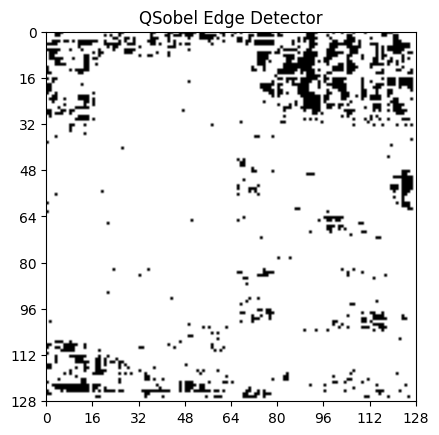

In [ ]:
# Display the edge-detected image
plt.title('QSobel Edge Detector')
plt.xticks(range(0, image.shape[0]+1, image_crop_size))
plt.yticks(range(0, image.shape[1]+1, image_crop_size))
plt.imshow(result, extent=[0, image.shape[0], image.shape[1], 0], cmap='binary_r')
plt.show()

In [ ]:
%qiskit_version_table